                                               OMNIGLOT- ONE SHOT LEARNING

The Omniglot is a handwritten dataset which contains 1623 hand drawn characters of 50 different alphabets(languages)
which are then spilt up into 30 background i.e. training set and 20 evaluation i.e testing set images. 
Every image is gray scale with resolution of 105*105. An example is shown below:
                    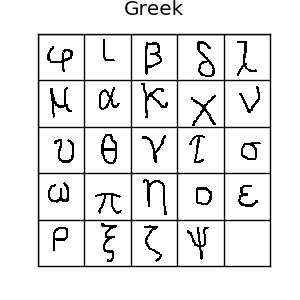

The main characteristic of the Omniglot dataset is the fact that it has very few examples for every class type
and also the testing dataset consists of totally different classes than 
the training classes which makes the prediction harder as the neural network 
will never have seen that particular data before.

This particular characteristic then inspired building up of an architecture inspired by human learning in one-shot approach. The key idea here is that humans, even small kids start to recognize things even if they had seen it only once before. This ability to learn rapidly with very less data was pretty lucrative and that is what inspired creation of the one-shot learning classifier algorithm.

My main motivation behind choosing the one-shot classifier was mainly
due to the dataset which I had to work upon because I had recently worked with the MNIST dataset and the idea to work with the transppose of such a dataset appealed to me.Also, the fact to be able to learn a new algorithm also motivated me. As we have very few examples per class,
we will need to train a network which can perform well even when it is trained using 
lesser data of similar classes. 
Further, to perform one-shot learning I have used the Siamese network architecture
which has two fully identical Convolutional Neural Networks as seen below. These two Convenets share their weights.

 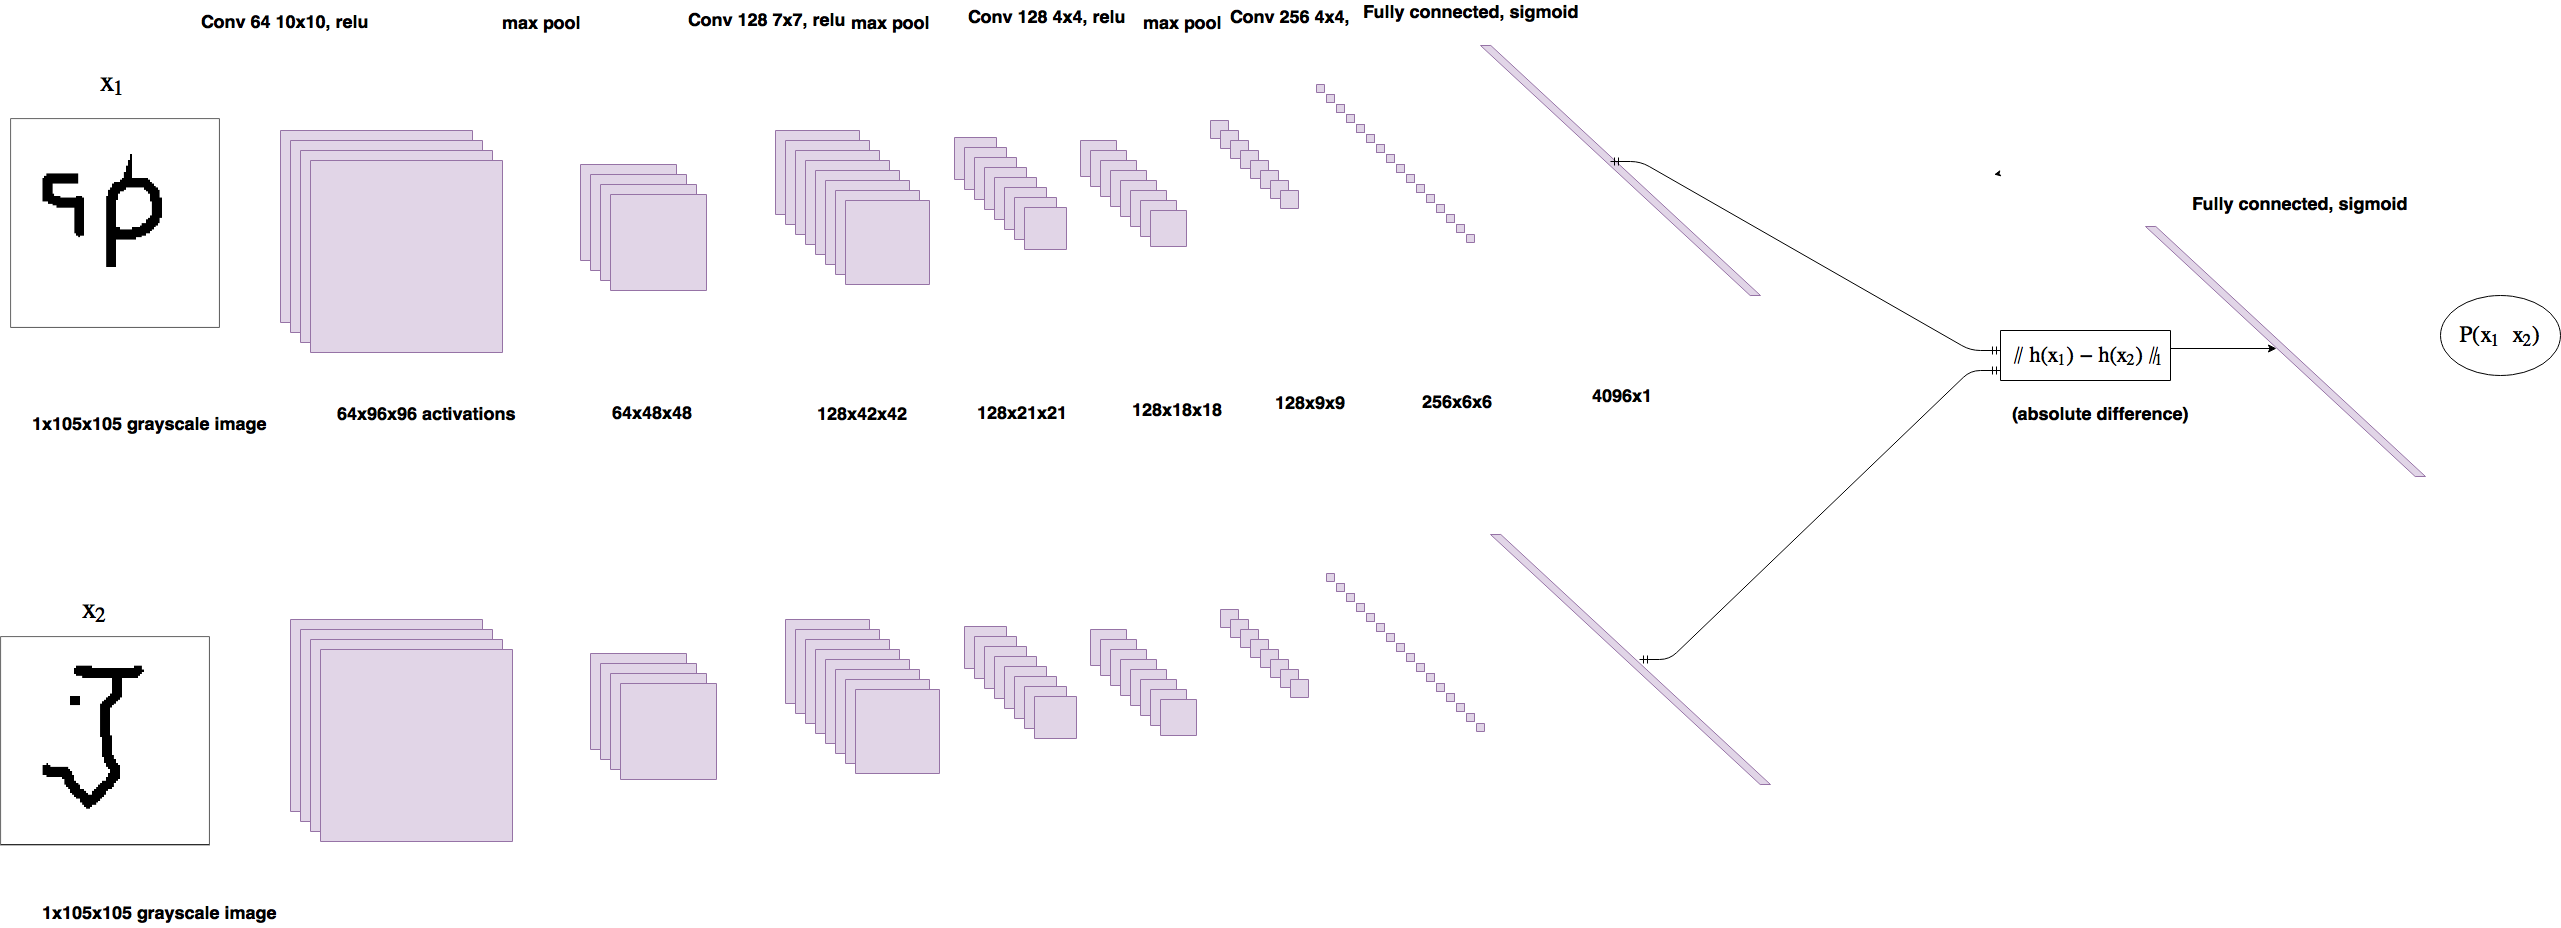

Both the CNNs have same weights and accept two different images. 
Normal CNN use softmax to get the classification, but here the output of 
fully connected layer is regarded as 128 dimensional encoding of the 
input image. First network output the encoding of the first input image and second network output the encoding of its input image.These networks are optimised based on the loss between their outputs. Loss is calculated using distance metric as shown below. Loss will be smaller, if the image are similar and will be further apart when images are not similar.

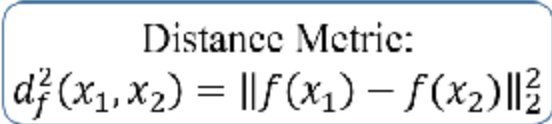


Here, I have used the concept of model agnostic meta-learning algorithm which achieves the goal of quickly learning a new task from a small number of examples. The main idea is that the model is trained such that the initial parameters give maximal performance on a new task once the parameters are updated using gradient descent for a small amount of data of the new task.

Let's dive into coding then!

LOADING THE DATASET

In [2]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
from scipy.ndimage import imread
import seaborn as sns
from sklearn.utils import shuffle

/Users/chaitralikshirsagar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


SPECIFYING PATH FOR TRAIN AND VALIDATION IMAGES

In [3]:
train_folder='/Users/chaitralikshirsagar/Downloads/images_background'
val_folder='/Users/chaitralikshirsagar/Downloads/images_evaluation'
save_path='/Users/chaitralikshirsagar/Downloads'

DEFINING FUNCTION TO LOAD IMAGES FROM REQUIRED PATH AND CREATE A DICTIONARY OF THE ALPHABETS AND ITS CHARACTERS. 

NOTE -  For MAC OS I observed that certain .DS_Store files get generated which cause an error while running the below cell. To take care of the same I ran the below command which remove all the .DS_Store files that are generated in that particular path: 
find . -name '.DS_Store' -type f -delete

In [6]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [7]:
X,y,c = loadimgs(train_folder)

loading alphabet: Gujarati


/Users/chaitralikshirsagar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


loading alphabet: Korean
loading alphabet: Arcadian
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Grantha
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Balinese
loading alphabet: Futurama
loading alphabet: N_Ko
loading alphabet: Burmese_(Myanmar)
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Latin
loading alphabet: Braille
loading alphabet: Sanskrit
loading alphabet: Japanese_(hiragana)
loading alphabet: Tagalog
loading alphabet: Greek
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(katakana)
loading alphabet: Early_Aramaic
loading alphabet: Hebrew
loading alphabet: Tifinagh
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Armenian
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Cyrillic
loading alphabet: Bengali
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)


The above function call returns three tuples: X contains 964 characters across 30 alphabets and size of each image, y contains total number of image labels (964*20) whereas c contains the categories for dictionary.

In [8]:
X.shape

(964, 20, 105, 105)

In [9]:
y.shape

(19280, 1)

In [10]:
c.keys()

dict_keys(['Gujarati', 'Korean', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Futurama', 'N_Ko', 'Burmese_(Myanmar)', 'Anglo-Saxon_Futhorc', 'Mkhedruli_(Georgian)', 'Latin', 'Braille', 'Sanskrit', 'Japanese_(hiragana)', 'Tagalog', 'Greek', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Early_Aramaic', 'Hebrew', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Armenian', 'Syriac_(Estrangelo)', 'Alphabet_of_the_Magi', 'Cyrillic', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)'])

Save the train data on disk

SAVE OUR TRAIN DATA IN PICKLE FILE FORMAT FOR LATER USAGE

In [11]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

In [12]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Oriya


/Users/chaitralikshirsagar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


loading alphabet: ULOG
loading alphabet: Tengwar
loading alphabet: Malayalam
loading alphabet: Atlantean
loading alphabet: Keble
loading alphabet: Manipuri
loading alphabet: Gurmukhi
loading alphabet: Tibetan
loading alphabet: Aurek-Besh
loading alphabet: Ge_ez
loading alphabet: Angelic
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Kannada
loading alphabet: Avesta
loading alphabet: Mongolian
loading alphabet: Syriac_(Serto)
loading alphabet: Atemayar_Qelisayer
loading alphabet: Sylheti
loading alphabet: Glagolitic


Save validation data on disk

In [13]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

WEIGHTS AND BIAS ARE INITIALIZED ACCORDING TO ONE SUGGESTED IN THE INITAL PAPER - 'http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf'

In [14]:
def initialize_weights(shape, name=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [15]:
def initialize_bias(shape, name=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

THE NETWORK IS DEFINED ALSO IN ACCORDANCE WITH THE PAPER ABOVE -'http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf;

In [16]:
def get_siamese_model(input_shape):
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [20]:
model = get_siamese_model((105, 105, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]               
          

I have used the Adam optimizer here as it is expected to provide a better output than other optimzers.

In [21]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [22]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Gujarati', 'Korean', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Futurama', 'N_Ko', 'Burmese_(Myanmar)', 'Anglo-Saxon_Futhorc', 'Mkhedruli_(Georgian)', 'Latin', 'Braille', 'Sanskrit', 'Japanese_(hiragana)', 'Tagalog', 'Greek', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Early_Aramaic', 'Hebrew', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Armenian', 'Syriac_(Estrangelo)', 'Alphabet_of_the_Magi', 'Cyrillic', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)']


In [23]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Oriya', 'ULOG', 'Tengwar', 'Malayalam', 'Atlantean', 'Keble', 'Manipuri', 'Gurmukhi', 'Tibetan', 'Aurek-Besh', 'Ge_ez', 'Angelic', 'Old_Church_Slavonic_(Cyrillic)', 'Kannada', 'Avesta', 'Mongolian', 'Syriac_(Serto)', 'Atemayar_Qelisayer', 'Sylheti', 'Glagolitic']


In [24]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [25]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [26]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [27]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

For the hyperparameters, I have set the number of iterations to a very small count due to the fact that I do not have any GPU on my system. Thus the training and testing are done for a very less time and hence the accuracy we get is not very high. But if we increase the number of iterations to a reasonable amount say 20000 epochs, we can see that accuracy of about 98% is achieved on training set whereas 90% or more accuracy is achieved on the validation set for state of art GPU based systems.

In [29]:
# Hyper parameters
evaluate_every = 2 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 10 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [30]:
model_path = '/Users/chaitralikshirsagar/Downloads/'

In [31]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        #model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 2 iterations: 0.6138438026110331 mins
Train Loss: 4.4825544357299805
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 31.2% 20 way one-shot learning accuracy 

Current best: 31.2, previous best: -1

 ------------- 

Time for 4 iterations: 23.760706885655722 mins
Train Loss: 4.444247245788574
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 34.8% 20 way one-shot learning accuracy 

Current best: 34.8, previous best: 31.2

 ------------- 

Time for 6 iterations: 28.605733184019723 mins
Train Loss: 4.381310939788818
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 30.0% 20 way one-shot learning accuracy 


 ------------- 

Time for 8 iterations: 33.4998325864474 mins
Train Loss: 4.363516807556152
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 32.8% 20

In [32]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [33]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [34]:
ways = np.arange(1,20,2)
resume =  False
trials = 5

In [35]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 5 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 5 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 5 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 5 random 3 way one-shot learning tasks ... 

Got an average of 60.0% 3 way one-shot learning accuracy 

Evaluating model on 5 random 3 way one-shot learning tasks ... 

Got an average of 80.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 5 unique 3 way one-shot learning tasks ...
NN Accuracy =  80.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 5 random 5 way one-shot learning tasks ... 

Got an average of 60.0

In [36]:
PATH='/Users/chaitralikshirsagar/Downloads/'

In [45]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 26 10:13:35 2019

@author: chaitralikshirsagar
"""
import numpy as np
import os
from scipy.ndimage import imread

# Parameters
nrun = 20 # number of classification runs
fname_label = 'class_labels.txt' # where class labels are stored for each run

def classification_run(folder):

    data=[]
    train_files=[]
    test_files=[]
    
    fpath=os.path.join(folder,fname_label)
    for line in open(fpath,'r'):
        data.append(line.split())
        
    for i in range(nrun):
        test_files.append(data[i][0])
        train_files.append(data[i][1])
    
    target_files=train_files.copy()
    train_files=sorted(train_files)
    test_files=sorted(test_files)
    
    trainlen=len(train_files)
    testlen=len(test_files)
    
    img_test=[LoadImage('/Users/chaitralikshirsagar/Downloads/all_runs'+'/'+f)for f in test_files] 
    img_train=[LoadImage('/Users/chaitralikshirsagar/Downloads/all_runs'+'/'+f)for f in train_files]       
#    
    cost = np.zeros((testlen,trainlen))
    
    for i in range(testlen):
        for  j in range(trainlen):
            cost[i,j]=Distance_Calc(img_test[i],img_train[j])

    predicted_y=np.argmax(cost,axis=1)

    count=0
    for i in range(testlen):
        if(train_files[predicted_y[i]]==target_files[i]):
            count=count+1
    accuracy = (count/float(testlen))
    error = 1 - accuracy
    return error*100

def LoadImage(img_label):
    
    Image=imread(img_label,flatten=True)
    return Image

def Distance_Calc(A,B):
    a1= A.reshape(1,105,105,1)
    b1=B.reshape(1,105,105,1)
    c = np.stack((a1,b1))
    c = list(c)
    p = model.predict(c)
    return p

if __name__ == "__main__":
    
    print ('One-shot classification ')
    perror = np.zeros(nrun)
    for r in range(1,nrun+1):
        rs = str(r)
        if len(rs)==1:
            rs = '0' + rs
        perror[r-1] = classification_run('/Users/chaitralikshirsagar/Downloads/all_runs/run'+rs)
        print("run" + " "+ str(r)+" "+ "error {:.1f}% ".format(perror[r-1]))
    total = np.mean(perror)
    print("Average error {:.1f}%".format(total))

One-shot classification 


/Users/chaitralikshirsagar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


run 1 error 75.0% 
run 2 error 90.0% 
run 3 error 80.0% 
run 4 error 60.0% 
run 5 error 50.0% 
run 6 error 55.0% 
run 7 error 80.0% 
run 8 error 90.0% 
run 9 error 85.0% 
run 10 error 75.0% 
run 11 error 40.0% 
run 12 error 85.0% 
run 13 error 80.0% 
run 14 error 70.0% 
run 15 error 55.0% 
run 16 error 60.0% 
run 17 error 75.0% 
run 18 error 70.0% 
run 19 error 75.0% 
run 20 error 85.0% 
Average error 71.8%


Here, we run the above code on the all.runs folder which I downloaded from https://github.com/brendenlake. This folder contains different training and test images for 20 runs and each has a class label data included. For every iteration, model.predict is used to calculate probability based upon distance between the two images one from test and one from train folder. The label with the highest probability is assigned to the image and the accuracy is calculated.
As we can see from above results, we get very high errors since I have trained the model for very less number of iterations. But if we increase the iteration count we can see that the error reduces.

Thus, I implemented the One-shot learning algorithm on the OMNIGLOT dataset and saw the bewlow output plot. The plot is not a very good representation of actual accuracy because of smaller number of iterations and hence accuracy has suffered a lot. 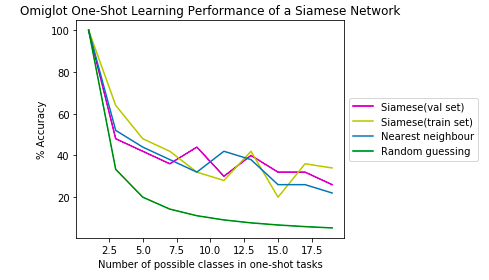

But we can still see that it is better than the accuracy which is achieved by random guessing approach.
The 20-shot images for similarity comparison can be represented as below:
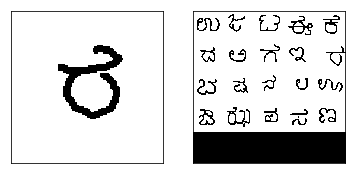

The major disadvantage that I found of the one-shot learning algorithm is that while testing, the test image is compared to only one image at a time and not to the entire set as a whole.One possible improvement can be to compare the test image to an entire set together. I also feel normalizing the dataset beforehand will be a good idea to avoid any possible corrupted images or remove noise from the given images. This will ensure that the accuracy is not affected due to bad signal input.
Also I implemented the model using the configuration described in the paper but we can definitely use other state of art architectures such as ResNet,InceptionNet etc. for feature extraction which might provide us with a higher accuracy.